In [41]:
import textwrap
from typing import Dict, List, Union, Optional
from urllib.request import urlretrieve

from bs4 import BeautifulSoup
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests

The US Census Bureau (USCB) runs a massive array of surveys of residents of the United States. After aggregating responses into demographic and/or geographic groups, the USCB publishes those aggregated datasets to its massive public data catalog. I've already developed some tooling to collect and ingest Census datasets into my personal data warehouse and analytics environment, but to map out geographic Census data or join in other geospatial datasets, I also need to collect and ingest spatial files describing the geographic boundaries of Census groupings. Fortunately, the USCB provides shapefiles with these geometries in their TIGER (Topologically Integrated Geographic Encoding and Referencing) data offerings, and in this notebook, I'll synthesize the findings the experiments and research in my last notebook into a data model and data collection tools.

### References:
* [TIGER Technical Docs](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.2022.html)
* [TIGER Geographic Codes](https://www.census.gov/programs-surveys/geography/technical-documentation/code-lists.html)

Each year, the USCB can add or alter geographic boundaries or connected data features, so they organize TIGER data offering into annual vintages, which can be downloaded either through the USCB web interface or from their [file server interface](https://www2.census.gov/geo/tiger/) (https://www2.census.gov/geo/tiger/).

The functions in the cell below aid in scraping the table off of any of pages linked in that file-tree interface.

In [4]:
#| code-fold: show

def request_page(metadata_url: str) -> requests.models.Response:
    resp = requests.get(metadata_url)
    if resp.status_code == 200:
        return resp
    else:
        raise Exception(f"Couldn't get page metadata for url {metadata_url}")

def scrape_census_ftp_metadata_page(metadata_url: str) -> pd.DataFrame:
    resp = request_page(metadata_url=metadata_url)
    soup = BeautifulSoup(resp.content, "html.parser")
    table = soup.find("table")
    rows = table.find_all("tr")
    table_contents = []
    for row in rows:
        cols = row.find_all("td")
        cols = [col.text.strip() for col in cols]
        table_contents.append(cols)
    table_rows = [el for el in table_contents if len(el) > 0]

    metadata_df = pd.DataFrame(
        [row[1:] for row in table_rows],
        columns=["name", "last_modified", "size", "description"],
    )
    metadata_df["last_modified"] = pd.to_datetime(metadata_df["last_modified"])
    metadata_df["is_dir"] = metadata_df["name"].str.endswith("/")
    metadata_df["clean_name"] = metadata_df["name"].str.replace("/$", "", regex=True)
    metadata_df["is_file"] = (~metadata_df["is_dir"]) & (
        metadata_df["clean_name"] != "Parent Directory"
    )
    while metadata_url.strip().endswith("/"):
        metadata_url = metadata_url[:-1]
    mask = metadata_df["is_file"] | metadata_df["is_dir"]
    metadata_df = metadata_df.loc[mask].copy()
    metadata_df["metadata_url"] = (metadata_url + "/" + metadata_df["clean_name"])
    return metadata_df

`request_page()` makes a GET request for the content at the URL `metadata_url` and returns the response (if successful, i.e. if the response has the "success" HTTP response status code). This function is only called by `scrape_census_ftp_metadata_page()`, but it's separated out to make it easier to test `scrape_census_ftp_metadata_page()`.

In [5]:
#| code-fold: show

def request_page(metadata_url: str) -> requests.models.Response:
    resp = requests.get(metadata_url)
    if resp.status_code == 200:
        return resp
    else:
        raise Exception(f"Couldn't get page metadata for url {metadata_url}")

`scrape_census_ftp_metadata_page()` gets the content from a given Census file-tree page (at URL `metadata_url`), parses it into a convenient and well structured format (a `pandas DataFrame`) with features that aid in filtering to desired rows.

In [10]:
resp = request_page(metadata_url="https://www2.census.gov/geo/tiger/")
soup = BeautifulSoup(resp.content, "html.parser")
table = soup.find("table")
rows = table.find_all("tr")
rows[0:7]

[<tr><th valign="top"><img alt="[ICO]" src="/icons/blank.gif"/></th><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr>,
 <tr><th colspan="5"><hr/></th></tr>,
 <tr><td valign="top"><img alt="[PARENTDIR]" src="/icons/back.gif"/></td><td><a href="/geo/">Parent Directory</a></td><td> </td><td align="right">  - </td><td> </td></tr>,
 <tr><td valign="top"><img alt="[   ]" src="/icons/layout.gif"/></td><td><a href="Directory_Contents_ReadMe.pdf">Directory_Contents_ReadMe.pdf</a></td><td align="right">2019-06-25 09:13  </td><td align="right">439K</td><td> </td></tr>,
 <tr><td valign="top"><img alt="[DIR]" src="/icons/folder.gif"/></td><td><a href="GENZ2010/">GENZ2010/</a></td><td align="right">2013-07-24 12:46  </td><td align="right">  - </td><td> </td></tr>,
 <tr><td valign="top"><img alt="[DIR]" src="/icons/folder.gif"/></td><td><a href="GENZ2012/">GENZ2012/</a></td><td align="r

The cell above shows code that extracts HTML `tr` (table-row) elements extracted from the page (sorry for showing something so ugly!), and the cell below shows the (beautiful) end product of `scrape_census_ftp_metadata_page()`.

In [11]:
#| code-fold: show
all_tiger_vintages_df = scrape_census_ftp_metadata_page(
    metadata_url="https://www2.census.gov/geo/tiger/"
)
display(all_tiger_vintages_df.head(4))

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
1,Directory_Contents_ReadMe.pdf,2019-06-25 09:13:00,439K,,False,Directory_Contents_ReadMe.pdf,True,https://www2.census.gov/geo/tiger/Directory_Co...
2,GENZ2010/,2013-07-24 12:46:00,-,,True,GENZ2010,False,https://www2.census.gov/geo/tiger/GENZ2010
3,GENZ2012/,2013-07-24 12:47:00,-,,True,GENZ2012,False,https://www2.census.gov/geo/tiger/GENZ2012
4,GENZ2013/,2014-07-02 08:28:00,-,,True,GENZ2013,False,https://www2.census.gov/geo/tiger/GENZ2013


In [26]:
#| code-fold: true
print(f"Files on the top-level TIGER dataset page:                {all_tiger_vintages_df['is_file'].sum():>3}")
print(f"TIGER data offerings on the top-level TIGER dataset page: {all_tiger_vintages_df['is_dir'].sum():>3}")

Files on the top-level TIGER dataset page:                  1
TIGER data offerings on the top-level TIGER dataset page:  59


The `GENZyyyy` TIGER data offerings are interesting, but the real wealth of geospatial files can be found in the TIGER offerings with names matching the `TIGERyyyy` pattern, and I implemented the `get_tiger_vintages_metadata()` function to get the metadata for these offerings, or **vintages**.

In [25]:
#| code-fold: show

def get_tiger_vintages_metadata() -> pd.DataFrame:
    all_tiger_vintages_df = scrape_census_ftp_metadata_page(
        metadata_url="https://www2.census.gov/geo/tiger/"
    )
    tiger_vintages_df = all_tiger_vintages_df.loc[
        all_tiger_vintages_df["name"].str.contains("^TIGER\d{4}/", regex=True)
    ].copy()
    tiger_vintages_df = tiger_vintages_df.sort_values(by="name", ignore_index=True)
    return tiger_vintages_df

tiger_vintages_df = get_tiger_vintages_metadata()
print(f"Available TIGER vintages:")
names = textwrap.wrap(", ".join(list(tiger_vintages_df["clean_name"].values)), width=95)
for line in names:
    print(f"    {line}")
display(tiger_vintages_df.head(3))

Available TIGER vintages:
    TIGER1992, TIGER1999, TIGER2002, TIGER2003, TIGER2008, TIGER2009, TIGER2010, TIGER2011,
    TIGER2012, TIGER2013, TIGER2014, TIGER2015, TIGER2016, TIGER2017, TIGER2018, TIGER2019,
    TIGER2020, TIGER2021, TIGER2022


,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
0,TIGER1992/,2011-12-19 07:56:00,-,,True,TIGER1992,False,https://www2.census.gov/geo/tiger/TIGER1992
1,TIGER1999/,2012-02-13 11:19:00,-,,True,TIGER1999,False,https://www2.census.gov/geo/tiger/TIGER1999
2,TIGER2002/,2015-05-05 18:37:00,-,,True,TIGER2002,False,https://www2.census.gov/geo/tiger/TIGER2002


Now that we have tools for scraping the any page in the Census's file server, we can use those tools to retrieve data on the geographic entities in a given TIGER vintage.

In [35]:
#| code-fold: show

class TIGERCatalog:
    def __init__(self):
        self.dataset_vintages = get_tiger_vintages_metadata()

    def get_vintage_metadata(self, year: str) -> pd.DataFrame:
        return self.dataset_vintages.loc[self.dataset_vintages["name"] == f"TIGER{year}/"].copy()

class TIGERVintageCatalog:
    def __init__(self, year: str, catalog: Optional[TIGERCatalog] = None):
        self.year = str(year)
        self.set_catalog(catalog=catalog)

    def set_catalog(self, catalog: Optional[TIGERCatalog]) -> None:
        if catalog is None:
            self.catalog = TIGERCatalog()
        else:
            self.catalog = catalog

    @property
    def vintage_metadata(self):
        return self.catalog.get_vintage_metadata(year=self.year)

    @property
    def vintage_entities(self):
        if len(self.vintage_metadata) == 1:
            tiger_vintage_url = self.vintage_metadata["metadata_url"].values[0]
            return scrape_census_ftp_metadata_page(metadata_url=tiger_vintage_url)
        else:
            raise Exception(
                f"Failed to get unambiguous metadata (got {self.vintage_metadata})"
            )

    def get_entity_metadata(self, entity_name: str) -> pd.DataFrame:
        return self.vintage_entities.loc[self.vintage_entities["clean_name"] == entity_name].copy()

    def print_entity_names(self):
        entity_names = self.vintage_entities.loc[
            self.vintage_entities["is_dir"], "clean_name"
        ].values
        print(f"TIGER Entity options for the {self.year} TIGER vintage:")
        for entity_name in entity_names:
            print(f"  - {entity_name}")
        print(f"Entity count: {len(entity_names)}")

In [34]:
tiger_catalog = TIGERCatalog()
vintage_entity_catalog = TIGERVintageCatalog(year="2022", catalog=tiger_catalog)
vintage_entity_catalog.print_entity_names()

TIGER Entity options for the 2022 TIGER vintage:
  - ADDR
  - ADDRFEAT
  - ADDRFN
  - AIANNH
  - AITSN
  - ANRC
  - AREALM
  - AREAWATER
  - BG
  - CD
  - COASTLINE
  - CONCITY
  - COUNTY
  - COUSUB
  - EDGES
  - ELSD
  - ESTATE
  - FACES
  - FACESAH
  - FACESAL
  - FACESMIL
  - FEATNAMES
  - LINEARWATER
  - MIL
  - PLACE
  - POINTLM
  - PRIMARYROADS
  - PRISECROADS
  - PUMA
  - RAILS
  - ROADS
  - SCSD
  - SDADM
  - SLDL
  - SLDU
  - STATE
  - SUBBARRIO
  - TABBLOCK20
  - TBG
  - TRACT
  - TTRACT
  - UAC
  - UNSD
  - ZCTA520
Entity count: 44


Let's examine Census Tracts.

I'll need some tooling to collect information on a given entity in a given TIGER vintage. I know this object will need data that's in the relevant `TIGERVintageCatalog` instance, so I'll make that an attribute of 
the entity vintage class. I could require that the use passes in a `TIGERVintageCatalog` instance (which would reduce the number of calls to the same Census resource in the usecase where a user is interactively working using these classes), but ultimately I'm going to build out pipelines that only collect one TIGER entity at a from a given vintage (as I don't need most of the available entities listed above).

In [36]:
class TIGERGeographicEntityVintage:
    def __init__(self, entity_name: str, year: str, catalog: Optional[TIGERCatalog] = None):
        self.entity_name = entity_name
        self.year = str(year)
        self.vintage_catalog = TIGERVintageCatalog(year=year, catalog=catalog)
        self.entity_metadata = self.vintage_catalog.get_entity_metadata(entity_name=self.entity_name)

    @property
    def entity_url(self):
        return self.entity_metadata["metadata_url"].values[0]

tiger_tract22_obj = TIGERGeographicEntityVintage(entity_name="TRACT", year="2022", catalog=tiger_catalog)
display(tiger_tract22_obj.entity_metadata)
entity_df = scrape_census_ftp_metadata_page(metadata_url=tiger_tract22_obj.entity_url)
print(entity_df.shape)
display(entity_df.head(2))

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
41,TRACT/,2022-09-30 22:39:00,-,,True,TRACT,False,https://www2.census.gov/geo/tiger/TIGER2022/TRACT


(56, 8)


,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
1,tl_2022_01_tract.zip,2022-10-31 19:42:00,11M,,False,tl_2022_01_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...
2,tl_2022_02_tract.zip,2022-10-31 19:42:00,3.0M,,False,tl_2022_02_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...


Looking at the names, I see that the Census groups tracts by state **FIPS** code (Federal Information Processing Series code). I know the FIPS code for Illinois is "17" (you can review the FIPS codes for other geographic entities [here](https://www.census.gov/library/reference/code-lists/ansi.html)). I also know I don't always want to pull data for all states, so I need to add a method that allows the user to filter the entity files. Also, I should build in the step of getting the entity files metadata.

In [47]:
class TIGERGeographicEntityVintage:
    def __init__(self, entity_name: str, year: str, catalog: Optional[TIGERCatalog] = None):
        self.entity_name = entity_name
        self.year = str(year)
        self.vintage_catalog = TIGERVintageCatalog(year=year, catalog=catalog)
        self.entity_metadata = self.vintage_catalog.get_entity_metadata(entity_name=self.entity_name)

    @property
    def entity_url(self):
        return self.entity_metadata["metadata_url"].values[0]

    @property
    def entity_files_metadata(self):
        return scrape_census_ftp_metadata_page(metadata_url=self.entity_url)

    def get_entity_file_metadata(self, filter_str: str) -> pd.DataFrame:
        return self.entity_files_metadata.loc[self.entity_files_metadata["name"].str.contains(filter_str)].copy()

tiger_tract22_obj = TIGERGeographicEntityVintage(entity_name="TRACT", year="2022", catalog=tiger_catalog)
il_tracts22_metadata = tiger_tract22_obj.get_entity_file_metadata(filter_str="_17_")
display(il_tracts22_metadata)
print(f"IL Tracts archive download Url: {il_tracts22_metadata['metadata_url'].values[0]}")

,name,last_modified,size,description,is_dir,clean_name,is_file,metadata_url
14,tl_2022_17_tract.zip,2022-10-31 19:43:00,9.5M,,False,tl_2022_17_tract.zip,True,https://www2.census.gov/geo/tiger/TIGER2022/TR...


IL Tracts archive download Url: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_17_tract.zip


Geopandas provides some extremely convenient functionality for loading data. I can provide the URL to a zipped archive (of geospatial files) to `geopandas`' `read_file()` function and it handles the network request and unzipping for me.

In [48]:
#| code-fold: show

il_tracts_gdf = gpd.read_file(il_tracts22_metadata["metadata_url"].values[0])

In [49]:
#| code-fold: true

print(il_tracts_gdf.shape)
il_tracts_gdf.head(2)

(3265, 13)


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,019,010701,17019010701,107.01,Census Tract 107.01,G5020,S,5266000,30553,+40.1150269,-088.0329549,"POLYGON ((-88.05240 40.11923, -88.05238 40.119..."
1,17,019,005902,17019005902,59.02,Census Tract 59.02,G5020,S,962402,4892,+40.1087344,-088.2247204,"POLYGON ((-88.22891 40.11271, -88.22882 40.112..."


And now I have plottable, spatially-joinable geospatial data ready to ingest into a data warehouse table or to plot out.

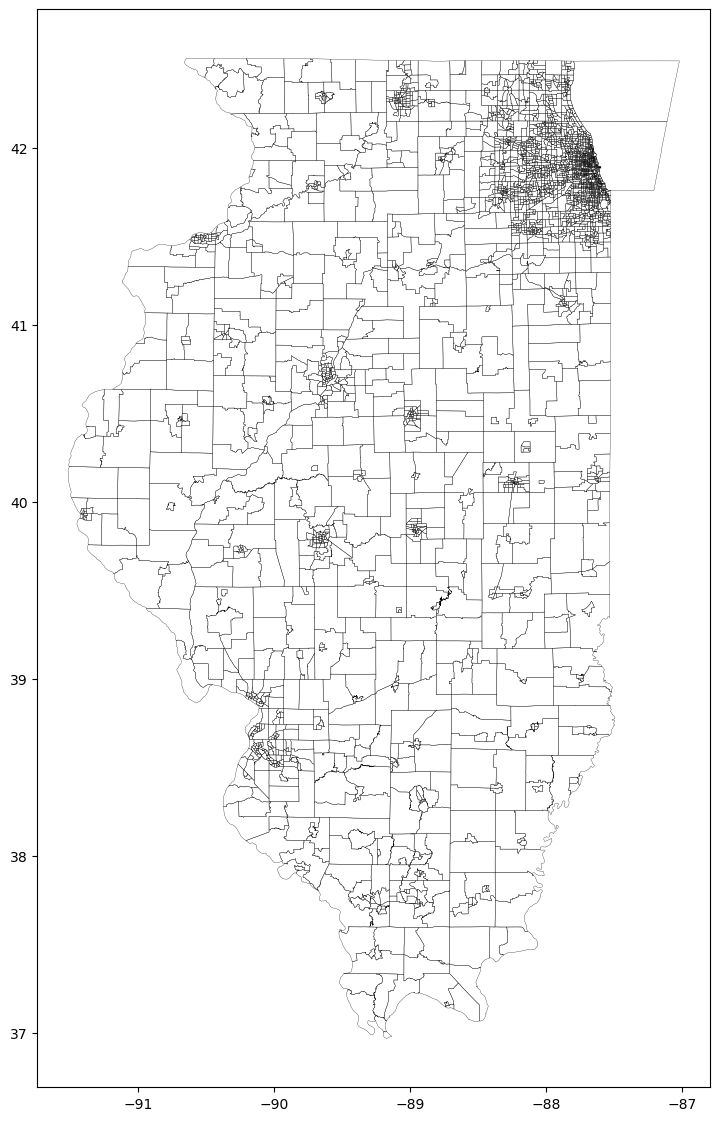

In [45]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = il_tracts_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)